In [2]:
import os
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [3]:




# 指定数据文件夹路径
folder_path = '/homes/Adam/DL_A3/us_data/test'
    
# 读取文件夹中的所有CSV文件并合并
all_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.csv')]
df_list = [pd.read_csv(file) for file in all_files]
all_data = pd.concat(df_list, ignore_index=True)

# 计算目标变量：当天收盘价与前一天收盘价的差
all_data['close_diff'] = all_data['$close'].diff()

all_data = all_data[1:] # 移除由于差分而产生的NaN值
all_data.info()

'''
基于距离的算法：如K最近邻（KNN）、支持向量机（SVM）和主成分分析（PCA），这些算法对数据的尺度非常敏感。在这种情况下，进行数值缩放是很重要的，因为它确保所有特征在距离计算中具有相同的重要性。
基于树的算法：如随机森林、梯度提升机（GBM）和决策树，这些算法对特征的尺度不敏感。因此，对于这类算法，数值缩放通常不是必需的。
'''

all_data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116890 entries, 1 to 116890
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   instrument       116890 non-null  object 
 1   datetime         116890 non-null  object 
 2   $close           116890 non-null  float64
 3   $volume          116890 non-null  float64
 4   Ref($close, 1)   116890 non-null  float64
 5   Mean($close, 3)  116890 non-null  float64
 6   $high-$low       116890 non-null  float64
 7   daily_return     116890 non-null  float64
 8   log_return       116890 non-null  float64
 9   volatility       116890 non-null  float64
 10  RSI              116890 non-null  float64
 11  MA_diff          116890 non-null  float64
 12  bollinger_upper  116890 non-null  float64
 13  bollinger_lower  116890 non-null  float64
 14  close_diff       116890 non-null  float64
dtypes: float64(13), object(2)
memory usage: 13.4+ MB


,instrument,datetime,$close,$volume,"Ref($close, 1)","Mean($close, 3)",$high-$low,daily_return,log_return,volatility,RSI,MA_diff,bollinger_upper,bollinger_lower,close_diff
1,MMM,2018-01-31,7.889697,99581544.0,7.922452,7.958463,0.111180,-0.004134,-0.004143,0.011787,63.862595,0.172009,8.120258,7.379390,-0.032755
2,MMM,2018-02-01,7.809067,84630350.0,7.889697,7.873739,0.123148,-0.010220,-0.010272,0.012263,58.008469,0.129889,8.106350,7.432069,-0.080630
3,MMM,2018-02-02,7.721824,124642030.0,7.809067,7.806863,0.121889,-0.011172,-0.011235,0.012527,50.978725,0.039097,8.096326,7.462439,-0.087243
4,MMM,2018-02-05,7.289387,209250140.0,7.721824,7.606759,0.579207,-0.056002,-0.057631,0.019560,36.489243,-0.088314,8.141172,7.388838,-0.432437
5,MMM,2018-02-06,7.358363,162183550.0,7.289387,7.456525,0.244408,0.009462,0.009418,0.019295,34.929211,-0.177804,8.163225,7.347384,0.068976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116886,SNI,2018-02-28,1.575386,423830370.0,1.572931,1.566678,0.021038,0.001560,0.001559,0.005473,75.875357,0.014691,1.571026,1.509619,0.002454
116887,SNI,2018-03-01,1.571529,111439560.0,1.575386,1.573282,0.014727,-0.002448,-0.002451,0.004761,84.415391,0.018432,1.575500,1.508037,-0.003857
116888,SNI,2018-03-02,1.582398,241153200.0,1.571529,1.576438,0.013324,0.006917,0.006893,0.004888,85.854420,0.022791,1.581245,1.505168,0.010870
116889,SNI,2018-03-05,1.579593,179636750.0,1.582398,1.577840,0.010168,-0.001773,-0.001774,0.004824,80.743736,0.024287,1.586448,1.503735,-0.002805


<Axes: title={'center': 'close, 3'}, xlabel='datetime', ylabel='Mean($close, 3)'>

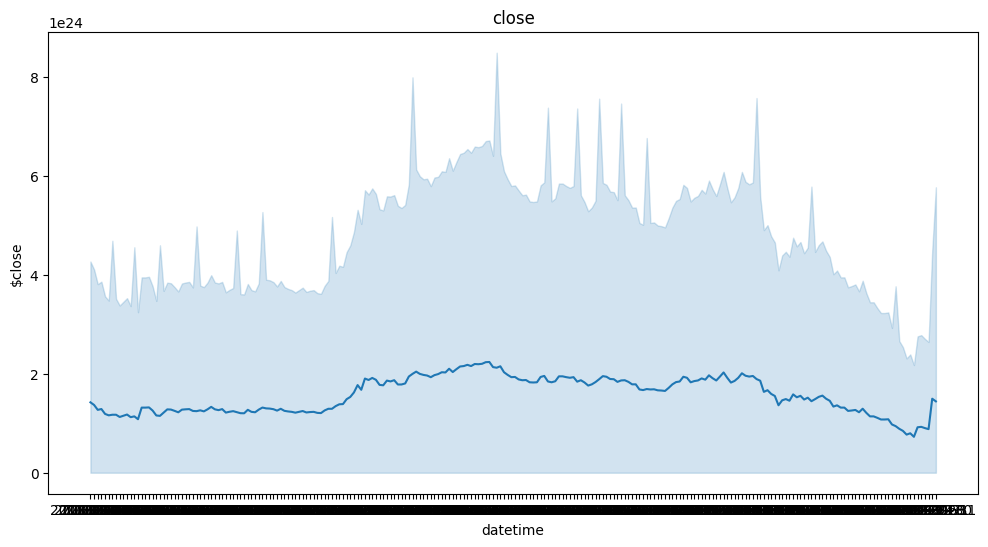

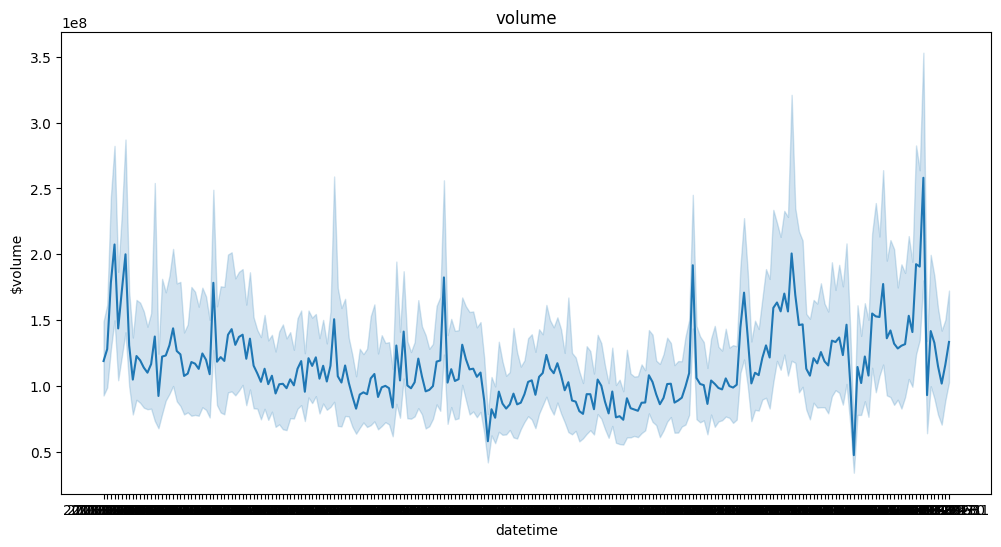

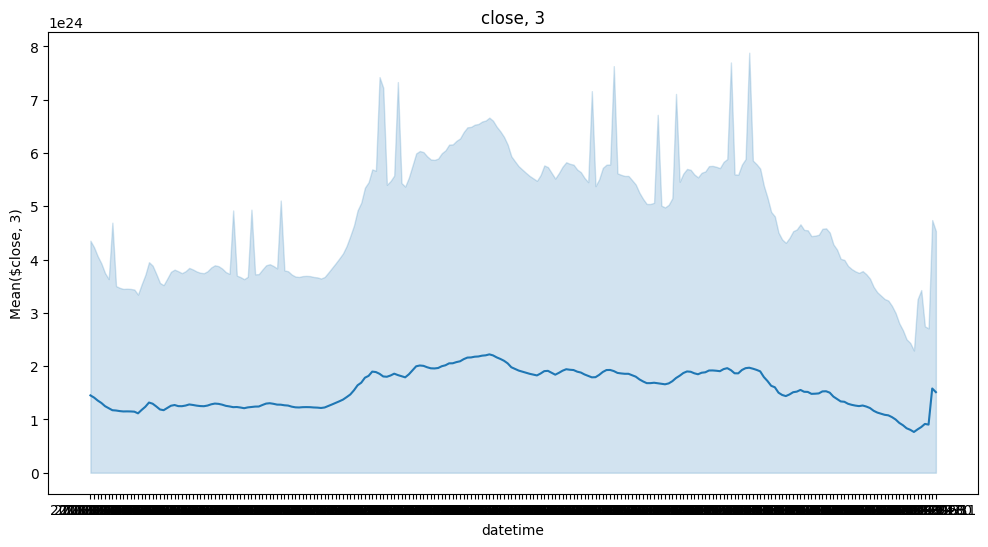

In [ ]:


# 假设df是您的DataFrame
plt.figure(figsize=(12, 6))
plt.title("close")
sns.lineplot(data=all_data, x='datetime', y='$close')

plt.figure(figsize=(12, 6))
plt.title("volume")
sns.lineplot(data=all_data, x='datetime', y='$volume')

plt.figure(figsize=(12, 6))
plt.title("close, 3")
sns.lineplot(data=all_data, x='datetime', y='Mean($close, 3)')


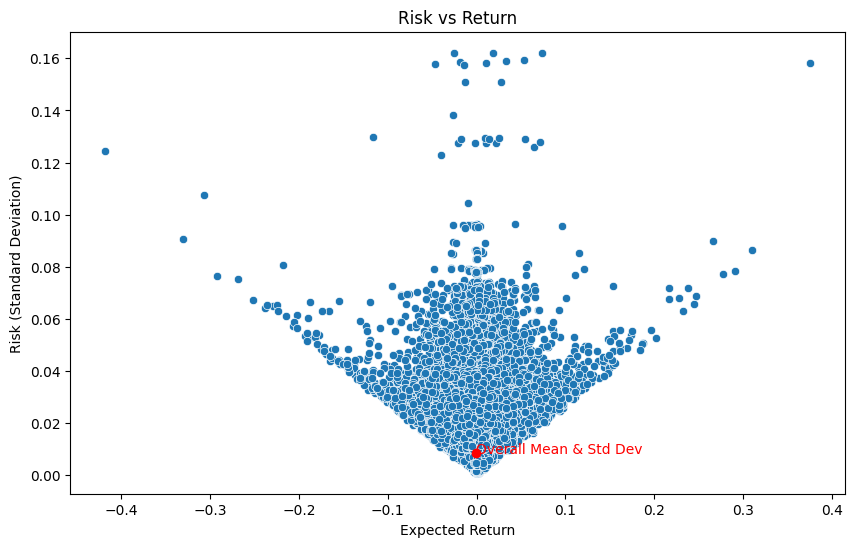

In [ ]:


plt.figure(figsize=(10, 6))
plt.title("Risk vs Return")

# Plotting a scatter plot for each data point in the dataset
sns.scatterplot(x='daily_return', y='volatility', data=all_data)

# Calculating and marking the overall mean and standard deviation
mean_return = all_data['daily_return'].mean()
std_deviation = all_data['volatility'].std()
plt.scatter(mean_return, std_deviation, color='red')  # Marking with red color
plt.text(mean_return, std_deviation, 'Overall Mean & Std Dev', color='red')

plt.xlabel('Expected Return')
plt.ylabel('Risk (Standard Deviation)')
plt.show()


/tmp/ipykernel_176538/2417291381.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


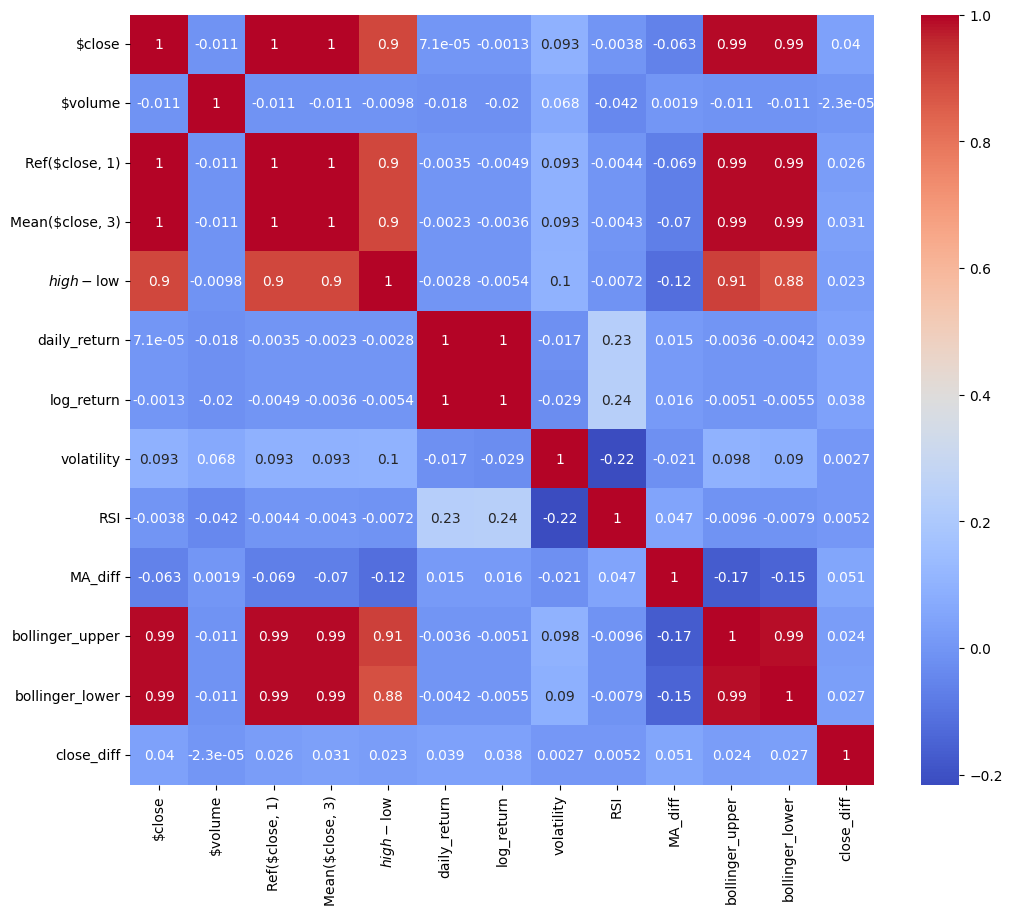

In [ ]:

# 计算特征之间的相关性
corr_matrix = all_data.corr()

# 绘制热力图显示特征之间的相关性
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [ ]:

# 设置相关性阈值
threshold = 0.8

# 创建一个集合，用于存储要删除的高度相关特征
to_drop = set()

# 遍历相关性矩阵
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            # 获取相关性高的特征名
            colname = corr_matrix.columns[i]
            to_drop.add(colname)

# 打印将要删除的特征
print("Features to drop:", to_drop)

# 从数据集中删除这些特征
data_reduced = data.drop(columns=to_drop)


# 显示调整后的数据集的前几行
print(data_reduced.head())



Features to drop: {'bollinger_upper', 'Mean($close, 3)', '$high-$low', 'Ref($close, 1)', 'log_return', 'bollinger_lower'}
  instrument    datetime    $close      $volume  daily_return  volatility  \
0        MMM  2018-01-30  7.922452   76600700.0     -0.017460    0.011664   
1        MMM  2018-01-31  7.889697   99581544.0     -0.004134    0.011787   
2        MMM  2018-02-01  7.809067   84630350.0     -0.010220    0.012263   
3        MMM  2018-02-02  7.721824  124642030.0     -0.011172    0.012527   
4        MMM  2018-02-05  7.289387  209250140.0     -0.056002    0.019560   

         RSI   MA_diff  close_diff  
0  65.611650  0.173668         NaN  
1  63.862595  0.172009   -0.032755  
2  58.008469  0.129889   -0.080630  
3  50.978725  0.039097   -0.087243  
4  36.489243 -0.088314   -0.432437  


/tmp/ipykernel_176538/223200359.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data_reduced.corr()


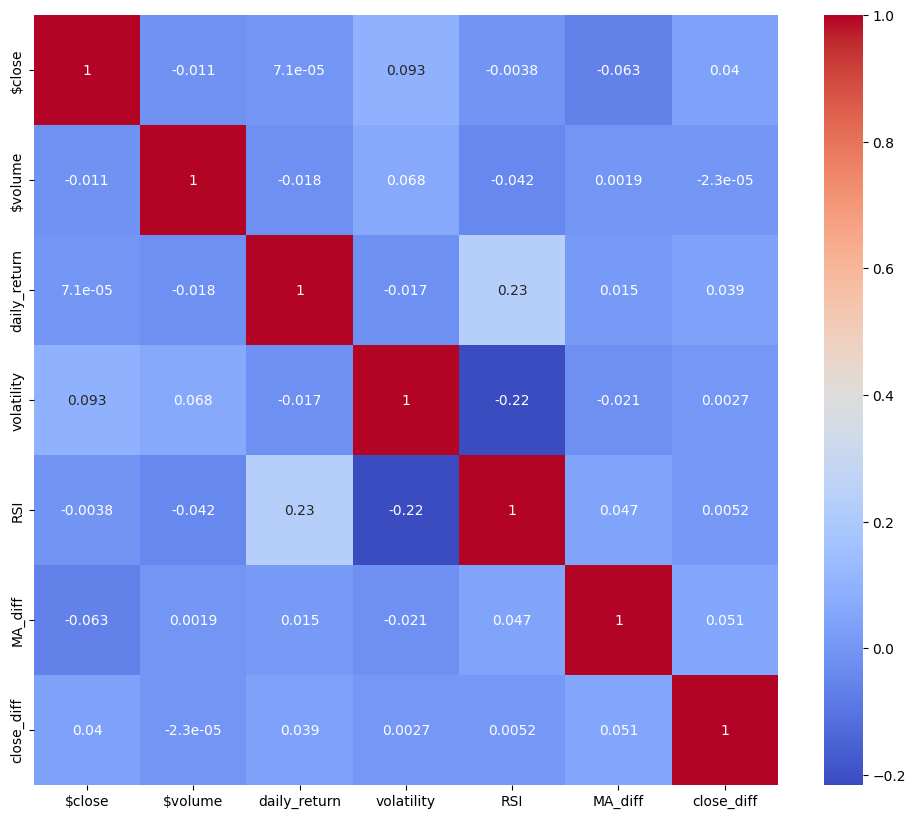

In [ ]:


# 计算特征之间的相关性
corr_matrix = data_reduced.corr()

# 绘制热力图显示特征之间的相关性
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()


In [11]:

def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs):
    gradient_norms = {name: [] for name, _ in model.named_parameters()}
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()  # 设置模型为训练模式
        total_loss = 0
        for sequences, labels in train_loader:
            labels = labels.float()
            optimizer.zero_grad()
            outputs = model(sequences)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            for name, param in model.named_parameters():
                if param.requires_grad:
                    gradient_norms[name].append(param.grad.norm().item())
            optimizer.step()
            total_loss += loss.item()
            # for name, param in model.named_parameters():
            #     if param.requires_grad:
            #         print(f"Epoch: {epoch}, Layer: {name}, Gradient: {param.grad.norm().item()}")
            
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        train_accuracy, _ = evaluate_accuracy_and_loss(model, train_loader, criterion)
        test_accuracy, avg_test_loss = evaluate_accuracy_and_loss(model, test_loader, criterion)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        test_losses.append(avg_test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

    return train_losses, test_losses, train_accuracies, test_accuracies,gradient_norms


def evaluate_accuracy_and_loss(model, data_loader, criterion):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient calculation during evaluation
        for sequences, labels in data_loader:
            labels = labels.float()
            outputs = model(sequences)
            outputs = outputs.squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            # For binary classification, apply a threshold of 0.5
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(data_loader)
    accuracy = 100 * correct / total
    return accuracy, avg_loss





In [3]:

stock = "AAPL"  # 根据需要更改股票代码
train_df = pd.read_csv(f'/homes/Adam/DL_A3/us_data/train/{stock}.csv')
test_df = pd.read_csv(f'/homes/Adam/DL_A3/us_data/test/{stock}.csv')


In [4]:
#数据处理

def create_three_class_labels(close_prices):
    """
    Create three-class classification labels based on closing prices.
    
    :param close_prices: Series of closing prices.
    :param threshold: Threshold to define a significant change.
    :return: Array of classification labels.
    """
    daily_changes = close_prices.pct_change().fillna(0)
    labels =np.where(daily_changes > 0, "Increase", "Decrease")
    
    return labels


# Create detailed labels for training and testing datasets
train_detailed_labels = create_three_class_labels(train_df['$close'])
test_detailed_labels = create_three_class_labels(test_df['$close'])

# Encode labels
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_detailed_labels)
test_labels_encoded = label_encoder.transform(test_detailed_labels)

# Select features
selected_features = ['$volume', 'Ref($close, 1)', 'daily_return', 'volatility', 'RSI', 'MA_diff']
selected_features = ['$volume', 'Ref($close, 1)', 'daily_return', 'volatility']

X_train = train_df[selected_features].values
X_test = test_df[selected_features].values

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def create_sequences(input_data, sequence_length):
    """
    Create sequences from input data.
    
    :param input_data: Scaled feature data.
    :param sequence_length: Length of the sequence.
    :return: Array of sequences.
    """
    sequences = []
    for i in range(len(input_data) - sequence_length):
        seq = input_data[i:i + sequence_length]
        sequences.append(seq)
    return np.array(sequences)

# Define sequence length and create sequences
sequence_length = 50
X_train_sequences = create_sequences(X_train_scaled, sequence_length)
X_test_sequences = create_sequences(X_test_scaled, sequence_length)

# Adjust labels for sequences

y_train_sequences = train_labels_encoded[sequence_length:]
y_test_sequences = test_labels_encoded[sequence_length:]

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_sequences, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_sequences, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_sequences, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_sequences, dtype=torch.long)

# Create DataLoader instances
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)



NameError: name 'train_df' is not defined

In [5]:


# 使用 Counter 来计数每个类别的出现次数
label_counts = Counter(train_detailed_labels)

# 打印每个类别的数量
for label, count in label_counts.items():
    print(f"Label '{label}': {count} occurrences")


NameError: name 'Counter' is not defined

In [53]:
#Focal Loss
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss


## RNN


In [12]:
class StockRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.5):
        super(StockRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)  # Output layer for binary classification

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Model instantiation
input_size = len(selected_features)  # Make sure this matches the number of features in your dataset
hidden_size = 5
num_layers = 2


In [13]:


num_epochs = 20
# 训练模型并获取损失和准确率
rnn_model = StockRNN(input_size, hidden_size, num_layers)

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)




train_losses, test_losses, train_accuracies, test_accuracies , gradient_norms = train_model(rnn_model, train_loader, test_loader, criterion, optimizer, num_epochs)

# 绘制损失图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()

# 绘制准确率图
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()

plt.show()

Epoch [1/20], Train Loss: 0.7368, Test Loss: 0.7325, Train Accuracy: 47.84%, Test Accuracy: 47.25%
Epoch [2/20], Train Loss: 0.7166, Test Loss: 0.7157, Train Accuracy: 47.84%, Test Accuracy: 47.25%
Epoch [3/20], Train Loss: 0.7045, Test Loss: 0.7053, Train Accuracy: 47.84%, Test Accuracy: 47.25%
Epoch [4/20], Train Loss: 0.7047, Test Loss: 0.6996, Train Accuracy: 47.84%, Test Accuracy: 47.25%
Epoch [5/20], Train Loss: 0.7017, Test Loss: 0.6963, Train Accuracy: 47.84%, Test Accuracy: 47.25%


KeyboardInterrupt: 

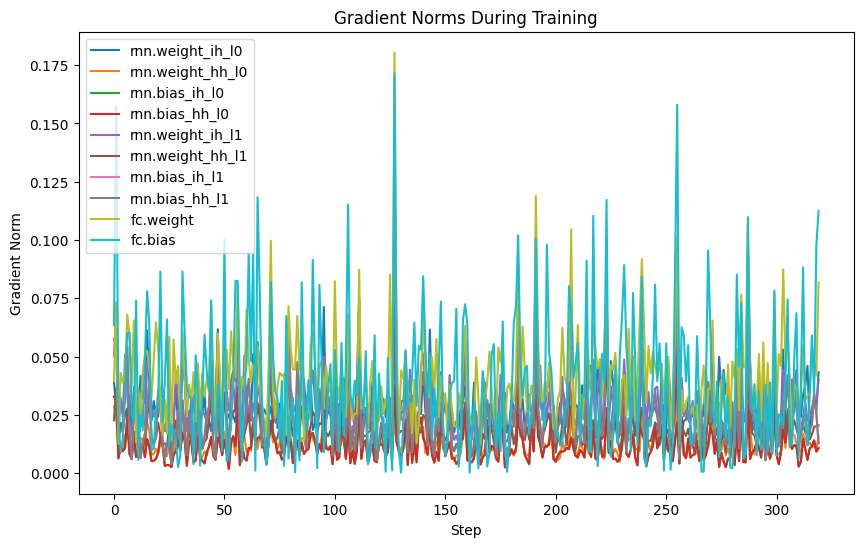

In [213]:
plt.figure(figsize=(10, 6))
for name, norms in gradient_norms.items():
    plt.plot(norms, label=name)
plt.xlabel('Step')
plt.ylabel('Gradient Norm')
plt.title('Gradient Norms During Training')
plt.legend()
plt.show()

## CNN_RNN


In [67]:
import torch.nn as nn

class CNNRNNStockModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(CNNRNNStockModel, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # CNN layers
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)

        # RNN layers
        self.rnn = nn.RNN(input_size=64, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # CNN forward
        x = x.permute(0, 2, 1)  # Reshape x to (batch_size, input_size, seq_length)
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # RNN forward
        x = x.permute(0, 2, 1)  # Reshape x back to (batch_size, seq_length, new_input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = out[:, -1, :]
        out = self.fc(out)

        return out




Epoch [1/50], Train Loss: 0.2522, Test Loss: 0.2405, Train Accuracy: 41.31%, Test Accuracy: 56.04%
Epoch [2/50], Train Loss: 0.2380, Test Loss: 0.2298, Train Accuracy: 54.89%, Test Accuracy: 60.44%
Epoch [3/50], Train Loss: 0.2267, Test Loss: 0.2218, Train Accuracy: 55.35%, Test Accuracy: 60.44%
Epoch [4/50], Train Loss: 0.2168, Test Loss: 0.2160, Train Accuracy: 55.30%, Test Accuracy: 60.44%
Epoch [5/50], Train Loss: 0.2119, Test Loss: 0.2118, Train Accuracy: 55.30%, Test Accuracy: 60.44%
Epoch [6/50], Train Loss: 0.2082, Test Loss: 0.2091, Train Accuracy: 55.30%, Test Accuracy: 60.44%
Epoch [7/50], Train Loss: 0.2007, Test Loss: 0.2076, Train Accuracy: 55.30%, Test Accuracy: 60.44%
Epoch [8/50], Train Loss: 0.2001, Test Loss: 0.2068, Train Accuracy: 55.30%, Test Accuracy: 60.44%
Epoch [9/50], Train Loss: 0.1954, Test Loss: 0.2059, Train Accuracy: 55.30%, Test Accuracy: 60.44%
Epoch [10/50], Train Loss: 0.1938, Test Loss: 0.2056, Train Accuracy: 55.30%, Test Accuracy: 60.44%
Epoch [11

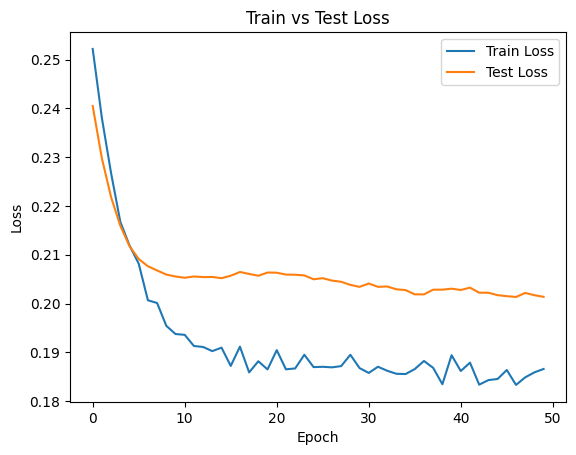

In [68]:
import matplotlib.pyplot as plt
import torch.optim as optim

# 实例化 Focal Loss
focal_loss_criterion = FocalLoss(alpha=0.25, gamma=2.0)

# 使用 Focal Loss 作为损失函数
criterion = focal_loss_criterion

# 实例化模型
cnnrnn_model = CNNRNNStockModel(input_size, hidden_size, num_layers, num_classes)

# 损失函数和优化器
# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnnrnn_model.parameters(), lr=0.0001)



num_epochs = 50
train_losses, test_losses, train_accuracies, test_accuracies = train_model(cnnrnn_model, train_loader, test_loader, criterion, optimizer, num_epochs)

# 绘制损失图
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.show()


## LSTM


In [150]:
class StockLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate=0.5):
        super(StockLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # Ensure dropout_rate is within the valid range
        if not 0 <= dropout_rate <= 1:
            raise ValueError("dropout_rate must be between 0 and 1")
        # Apply dropout only if there are multiple layers
        lstm_dropout = dropout_rate if num_layers > 1 else 0
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=lstm_dropout)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(out)
        return out

# Model instantiation
input_size = len(selected_features)
hidden_size = 5
num_layers = 3
model = StockLSTM(input_size, hidden_size, num_layers, 1)  # num_classes is 1 for binary classification

# Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [152]:
import torch.optim as optim

# 实例化 Focal Loss
focal_loss_criterion = FocalLoss(alpha=0.25, gamma=2.0)

criterion = nn.BCELoss()


# 实例化模型
LSTM_model = StockLSTM(input_size, hidden_size, num_layers, num_classes)

# 损失函数和优化器
optimizer = optim.Adam(LSTM_model.parameters(), lr=0.001)

num_epochs = 50
train_losses, test_losses, train_accuracies, test_accuracies = train_model(LSTM_model, train_loader, test_loader, criterion, optimizer, num_epochs)

# 绘制损失图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()

# 绘制准确率图
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy')
plt.legend()

plt.show()



ValueError: dropout_rate must be between 0 and 1

## GRU


In [16]:

class StockGRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout_rate):
        super(StockGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 在GRU层中添加dropout
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)

        # 添加一个dropout层在全连接层之前
        self.dropout = nn.Dropout(dropout_rate)

        # 由于是二分类问题，因此这里的输出应该是1
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # 初始化隐藏状态
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # 前向传播
        out, _ = self.gru(x, h0)
        out = out[:, -1, :]

        # 在全连接层之前应用dropout
        out = self.dropout(out)

        # 使用squeeze()去掉多余的维度
        out = self.fc(out).squeeze()

        return out


# 模型参数
input_size = len(selected_features)  # 特征数量
hidden_size = 50  # 隐藏层大小
num_layers = 2  # GRU层数
num_classes = len(np.unique(train_labels_encoded))  # 类别数量

# 实例化模型
model = StockGRU(input_size, hidden_size, num_layers, 0.5)
# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


In [17]:

num_epochs = 50
train_losses, test_losses = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs)

# 绘制损失图
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.show()
test_model(model, test_loader)


KeyboardInterrupt: 